# Setup entorno


In [1]:
import os
import pickle
import locale

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
)
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
import lightgbm as lgbm

import tensorflow as tf


from utils.data_mining import (
    create_feature_df,
    fill_missing_values,
    scale_data,
    analyze_categorical_variables,
    count_distinct,
    handle_outliers,
)

from utils.ml import (
    load_ml_model,
    model_results,
    goodness_of_fit,
    plot_roc_curve,
    plot_features_importance,
)

from utils.dl import (
    reshape_lstm_data,
    reshape_cnn_data,
    get_keras_lr_model,
    get_tuner_lr_model,
    get_lstm_model,
    get_cnn_model,
    plot_history,
)


import warnings

warnings.filterwarnings("ignore")
tf.get_logger().setLevel("ERROR")

In [2]:
# Constantes
SEED = 12345
WIDTH = 800
ML_DIR = "./trained_models/machine_learning/model/"
DL_DIR = "./trained_models/deep_learning/"

In [3]:
os.makedirs(ML_DIR, exist_ok=True)
os.makedirs(DL_DIR, exist_ok=True)

In [4]:
# Leer el dataset
dtypes = {
    "timestamp": "int64",
    "item_id": "object",
    "user_answer": "string",
    "user_id": "object",
    "content_type": "string",
    "bundle_id": "object",
    "answered_correctly": "int8",
    "content_id": "object",
    "elapsed_time": "float64",
    "bundle_had_explanation": "boolean",
    "prior_question_elapsed_time": "float32",
    "cumulative_correct_answers": "float32",
    "recent_accuracy": "float32",
    "cumulative_explanations_seen": "float32",
    "cumulative_lectures_seen": "float32",
    "cumulative_responses_by_bundle": "float32",
}

df = pd.read_csv("./data/ednet_dataset.csv", dtype=dtypes)

# EDA


- `timestamp` (int): El tiempo en milisegundos en el que el usuario realizó una acción.
- `item_id` (object): Código de identificación para el ítem (preguntas, lecciones o explicaciones).
- `user_answer` (string): La respuesta del usuario a la pregunta, si existe. El valor -1 se corresponde a las lecciones y explicaciones, debe leerse como un null.
- `user_id` (object): Código de identificación para el usuario.
- `content_type` (string): Un código de letra para el tipo de contenido (`q`=preguntas, `l`=lecciones, `e`=explicaciones).
- `bundle_id` (object): Código de identificación para el lote de preguntas, lecciones o explicaciones. (Por ejemplo, tres cuestiones, una explicación y una lección pueden pertenecer al mismo `bundle_id`).
- `answered_correctly` (int): Indica si el usuario respondió correctamente a la pregunta, si existe. El valor 1 corresponde a una respuesta correcta y el 0 a una incorrecta. El valor es null para lecciones y explicaciones. 
- `content_id` (object): Código de identificación para la interacción del usuario con el ítem.
- `elapsed_time` (float): El tiempo en milisegundos que tardó un usuario en responder una pregunta. El valor es null para lecciones y explicaciones.
- `bundle_had_explanation` (bool): Indica si el usuario vio una explicación después de responder al lote de preguntas anterior (`bundle_id`), ignorando cualquier lección entre medio. El valor se comparte a través del mismo lote de preguntas y es nulo para el primer lote de preguntas de un usuario. Generalmente, las primeras preguntas que ve un usuario forman parte de una prueba de diagnóstico inicial en la que no recibieron retroalimentación.
- `prior_question_elapsed_time` (float): El tiempo promedio en milisegundos que tardó un usuario en responder cada pregunta en el lote de preguntas anterior, ignorando cualquier lección entre medio (es nulo para el primer lote de preguntas).
- `cumulative_correct_answers` (float): El número acumulado de respuestas correctas que ha tenido el estudiante hasta ese momento. Aporta un indicador directo de cuánto ha acertado el estudiante hasta esa interacción, lo que puede ayudar a predecir su desempeño futuro.
- `recent_accuracy` (float): La precisión reciente del estudiante (en las últimas 5 preguntas), calculada como el porcentaje de respuestas correctas en un intervalo corto de tiempo. Este indicador puede ser útil para medir el "momentum" del estudiante, es decir, si está mejorando o empeorando en su desempeño.
- `cumulative_explanations_seen` (float): El número acumulado de explicaciones que ha visto el estudiante hasta ese momento. Este valor puede correlacionarse con una mejor comprensión de los contenidos si el estudiante tiende a consultar explicaciones con frecuencia.
- `cumulative_lectures_seen` (float): El número acumulado de lecciones que ha visto el estudiante hasta ese momento.
  Este valor puede correlacionarse con una mejor comprensión de los contenidos si el estudiante tiende a consultar lecciones con frecuencia.
- `cumulative_responses_by_bundle` (float): El número acumulado de preguntas respondidas por cada lote para cada estudiante.


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30771 entries, 0 to 30770
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   timestamp                       30771 non-null  int64  
 1   item_id                         30771 non-null  object 
 2   user_answer                     30771 non-null  string 
 3   user_id                         30771 non-null  object 
 4   content_type                    30771 non-null  string 
 5   bundle_id                       30771 non-null  object 
 6   answered_correctly              30771 non-null  int8   
 7   content_id                      30771 non-null  object 
 8   elapsed_time                    28195 non-null  float64
 9   bundle_had_explanation          18243 non-null  boolean
 10  prior_question_elapsed_time     17938 non-null  float32
 11  cumulative_correct_answers      18243 non-null  float32
 12  recent_accuracy                 

In [6]:
df.shape

(30771, 16)

In [7]:
df["content_type"].value_counts()

content_type
q    18243
e    11346
l     1182
Name: count, dtype: Int64

In [8]:
print("Porcentaje de datos faltantes por cada columna en los datos de preguntas")
print(df[df["content_type"] == "q"].isnull().sum() / len(df[df["content_type"] == "q"]))

Porcentaje de datos faltantes por cada columna en los datos de preguntas
timestamp                         0.000000
item_id                           0.000000
user_answer                       0.000000
user_id                           0.000000
content_type                      0.000000
bundle_id                         0.000000
answered_correctly                0.000000
content_id                        0.000000
elapsed_time                      0.141205
bundle_had_explanation            0.000000
prior_question_elapsed_time       0.016719
cumulative_correct_answers        0.000000
recent_accuracy                   0.000000
cumulative_explanations_seen      0.000000
cumulative_lectures_seen          0.000000
cumulative_responses_by_bundle    0.000000
dtype: float64


In [9]:
variables = list(df.columns)

numericas = df.select_dtypes(
    include=["int", "int32", "int64", "float", "float32", "float64"]
).columns

categoricas = [variable for variable in variables if variable not in numericas]

In [10]:
# A veces los 'nan' vienen como como una cadena de caracteres, los modificamos a perdidos.
for x in categoricas:
    df[x] = df[x].replace("nan", np.nan)

In [11]:
# Frecuencias de los valores en las variables categóricas
analyze_categorical_variables(df)

{'item_id':           n         %
 item_id              
 q6544    75  0.002437
 q5108    59  0.001917
 q3375    56  0.001820
 q6453    51  0.001657
 q3954    38  0.001235
 ...      ..       ...
 e5583     1  0.000032
 q8112     1  0.000032
 e457      1  0.000032
 q457      1  0.000032
 q10295    1  0.000032
 
 [10812 rows x 2 columns],
 'user_answer':                  n         %
 user_answer                 
 -1           12528  0.407137
 b             5138  0.166975
 c             4838  0.157226
 a             4829  0.156933
 d             3438  0.111729,
 'user_id':             n         %
 user_id                
 u327257  3730  0.121218
 u678188  3349  0.108836
 u17950   2939  0.095512
 u1178    2888  0.093855
 u6603    2527  0.082123
 ...       ...       ...
 u829292     3  0.000097
 u446960     2  0.000065
 u659230     2  0.000065
 u465161     2  0.000065
 u305394     1  0.000032
 
 [200 rows x 2 columns],
 'content_type':                   n         %
 content_type            

In [12]:
# Cuenta el número de valores distintos de cada una de las variables numéricas de un DataFrame
count_distinct(df)

,Column,Distinct
0,timestamp,28598
1,elapsed_time,402
2,prior_question_elapsed_time,577
3,cumulative_correct_answers,1401
4,recent_accuracy,12
5,cumulative_explanations_seen,1450
6,cumulative_lectures_seen,565
7,cumulative_responses_by_bundle,71


In [13]:
datos_input = df.drop(["answered_correctly"], axis=1)

variables_input = list(datos_input.columns)

numericas_input = datos_input.select_dtypes(
    include=["int", "int32", "int64", "float", "float32", "float64"]
).columns

num_outliers = [
    item for item in numericas_input if item not in ["timestamp", "content_id"]
]

# Contar el porcentaje de atipicos de cada variable.
resultados = {
    x: handle_outliers(datos_input[x])[1] / len(datos_input) for x in num_outliers
}
resultados

{'elapsed_time': 0.0,
 'prior_question_elapsed_time': 0.0,
 'cumulative_correct_answers': 0.0,
 'recent_accuracy': 0.0,
 'cumulative_explanations_seen': 0.0,
 'cumulative_lectures_seen': 0.04293003152318742,
 'cumulative_responses_by_bundle': 0.0}

In [14]:
descriptivos_num = df.describe().T
for num in numericas:
    descriptivos_num.loc[num, "Asimetria"] = df[num].skew()
    descriptivos_num.loc[num, "Kurtosis"] = df[num].kurtosis()
    descriptivos_num.loc[num, "Rango"] = np.ptp(df[num].dropna().values)

descriptivos_num

,count,mean,std,min,25%,50%,75%,max,Asimetria,Kurtosis,Rango
timestamp,30771.0,1.557895e+12,1.034649e+10,1.536081e+12,1.548468e+12,1.558502e+12,1.566970e+12,1.574784e+12,-0.037056,-1.452356,3.870261e+10
answered_correctly,30771.0,-6.756362e-02,8.614922e-01,-1.000000e+00,-1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,NaN,NaN,NaN
elapsed_time,28195.0,1.530329e+04,2.894964e+04,-1.000000e+00,-1.000000e+00,1.200000e+04,2.466700e+04,2.832000e+06,45.969025,3914.007648,2.832001e+06
prior_question_elapsed_time,17938.0,2.877388e+04,3.143860e+04,0.000000e+00,1.800000e+04,2.400000e+04,3.252206e+04,2.832000e+06,47.244335,3779.503906,2.832000e+06
cumulative_correct_answers,18243.0,3.672667e+02,3.635753e+02,0.000000e+00,6.000000e+01,2.350000e+02,5.970000e+02,1.399000e+03,0.936094,-0.222746,1.399000e+03
recent_accuracy,18243.0,5.748662e-01,2.729066e-01,0.000000e+00,4.000000e-01,6.000000e-01,8.000000e-01,1.000000e+00,-0.200106,-0.657592,1.000000e+00
cumulative_explanations_seen,30771.0,3.893869e+02,3.381570e+02,0.000000e+00,9.000000e+01,3.130000e+02,6.230000e+02,1.449000e+03,0.805703,-0.051442,1.449000e+03
cumulative_lectures_seen,30771.0,5.068607e+01,1.019611e+02,0.000000e+00,2.000000e+00,2.200000e+01,5.000000e+01,5.640000e+02,3.707588,14.116747,5.640000e+02
cumulative_responses_by_bundle,18243.0,2.747136e+00,4.474382e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00,7.000000e+01,6.492887,59.319469,6.900000e+01


In [15]:
print(f"Tenemos {df.bundle_id.nunique()} lotes únicos de cuestiones o lecciones.")

Tenemos 4959 lotes únicos de cuestiones o lecciones.


In [16]:
# Configurar el idioma para los nombres de los meses
locale.setlocale(locale.LC_TIME, "es_ES.UTF-8")

# Convertir `timestamp` a datetime y extraer mes y año
df["datetime"] = pd.to_datetime(df["timestamp"], unit="ms")
df["month_year"] = df["datetime"].dt.to_period("M")  # Periodos de mes y año

# Contar ocurrencias por mes y año
hist_data = df["month_year"].value_counts().reset_index()
hist_data.columns = ["month_year", "count"]
hist_data = hist_data.sort_values("month_year")  # Ordenar por fecha

# Convertir los periodos a cadenas formateadas para las etiquetas
hist_data["month_year"] = hist_data["month_year"].dt.strftime("%B %Y").str.capitalize()

# Crear el histograma con Plotly
fig = px.bar(
    hist_data,
    x="month_year",
    y="count",
    title="Histograma de Timestamp por Mes",
    labels={"month_year": "Mes", "count": "Cantidad"},
)

fig.update_layout(
    xaxis_title="Mes",
    yaxis_title="Cantidad",
    xaxis=dict(tickangle=45),
    template="plotly_white",
)

fig.show()

# Eliminar columnas temporales
df.drop(columns=["datetime", "month_year"], inplace=True)

In [17]:
ds = df["content_type"].value_counts().reset_index()

ds.columns = ["content_type", "percent"]

ds["percent"] /= len(df)

fig = px.pie(
    ds,
    names="content_type",
    values="percent",
    title="Tipo de contenido",
    width=WIDTH,
    height=500,
)

fig.show()

In [18]:
user_percent = (
    df[df.answered_correctly != -1]
    .groupby("user_id")["answered_correctly"]
    .agg(Mean="mean", Answers="count")
)
print(
    f"El número más alto de preguntas respondidas por un usuario es {user_percent.Answers.max()}."
)

El número más alto de preguntas respondidas por un usuario es 2109.


In [19]:
pq = df[df.answered_correctly != -1]
pq = pq[["prior_question_elapsed_time", "answered_correctly"]]
pq = pq.groupby(["answered_correctly"]).agg(
    {"answered_correctly": ["count"], "prior_question_elapsed_time": ["mean"]}
)

pq

,answered_correctly,prior_question_elapsed_time
,count,mean
answered_correctly,,
0,7794,30551.134766
1,10449,27452.048828


In [20]:
mean_pq = df.prior_question_elapsed_time.astype("float64").mean()

# Filtrar outliers usando percentiles
condition = (df.answered_correctly != -1) & (df.prior_question_elapsed_time.notna())
filtered_df = df[condition]
lower_bound = np.percentile(filtered_df.prior_question_elapsed_time, 1)
upper_bound = np.percentile(filtered_df.prior_question_elapsed_time, 99)

filtered_df = filtered_df[
    (filtered_df.prior_question_elapsed_time >= lower_bound)
    & (filtered_df.prior_question_elapsed_time <= upper_bound)
]

# Seleccionar muestra
pq = filtered_df[["prior_question_elapsed_time", "answered_correctly"]].sample(
    n=200, random_state=SEED
)

x = pq["prior_question_elapsed_time"]
y = pq["answered_correctly"]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

# Crear la figura con scatter y línea de tendencia
fig = px.scatter(
    pq,
    x="prior_question_elapsed_time",
    y="answered_correctly",
    title="Answered_correctly versus prior_question_elapsed_time",
    labels={
        "prior_question_elapsed_time": "Tiempo previo a la pregunta (ms)",
        "answered_correctly": "Respondió correctamente",
    },
)

# Añadir línea de tendencia
fig.add_trace(
    go.Scatter(
        x=x,
        y=p(x),
        mode="lines",
        name="Tendencia",
        line=dict(color="red", dash="dash"),
    )
)

# Añadir línea vertical para la media
fig.add_vline(
    x=mean_pq,
    line=dict(color="blue", dash="dash"),
    annotation_text="Mean",
    annotation_position="top right",
)

# Mostrar la figura
fig.update_layout(
    template="plotly_white",
    xaxis=dict(title="Tiempo previo a la pregunta (ms)"),
    yaxis=dict(title="Respondió correctamente"),
)
fig.show()

In [21]:
batch_lect = df.groupby(["bundle_id", "answered_correctly"]).size().unstack()
batch_lect.columns = ["Lecture", "Wrong", "Right"]
batch_lect["Lecture"] = batch_lect["Lecture"].fillna(0)
batch_lect = batch_lect.astype("Int64")
batch_lect["Percent_correct"] = batch_lect.Right / (batch_lect.Wrong + batch_lect.Right)
batch_lect["Percent_lecture"] = batch_lect.Lecture / (
    batch_lect.Lecture + batch_lect.Wrong + batch_lect.Right
)
batch_lect = batch_lect.sort_values(by="Percent_lecture", ascending=False)

print(
    f"El mayor número de lecciones vistas dentro de un único bundle_id es {batch_lect.Lecture.max()}."
)

El mayor número de lecciones vistas dentro de un único bundle_id es 29.


In [22]:
batch_lect["Has_lecture"] = np.where(batch_lect.Lecture == 0, False, True)
print(
 f"Tenemos {batch_lect[batch_lect.Has_lecture == True].shape[0]} bundle_id con lecciones\
 y {batch_lect[batch_lect.Has_lecture == False].shape[0]} bundle_id sin lecciones."
)

Tenemos 4692 bundle_id con lecciones y 267 bundle_id sin lecciones.


In [23]:
ds = df["user_id"].value_counts().reset_index()

ds.columns = ["user_id", "count"]

ds["user_id"] = ds["user_id"].astype(str) + "-"
ds = ds.sort_values(["count"]).tail(20)

fig = px.bar(
    ds,
    x="count",
    y="user_id",
    orientation="h",
    title="Top 20 usuarios por número de acciones",
    width=WIDTH,
    height=900,
)

fig.show()

In [24]:
ds = df["user_id"].value_counts().reset_index()

ds.columns = ["user_id", "count"]

ds = ds.sort_values("user_id")

fig = px.line(
    ds,
    x="user_id",
    y="count",
    title="Distribución de acciones de los usuarios",
    width=WIDTH,
    height=600,
)

fig.show()

In [25]:
ds = df["bundle_id"].value_counts().reset_index()

ds.columns = ["bundle_id", "count"]

ds["bundle_id"] = ds["bundle_id"].astype(str) + "-"
ds = ds.sort_values(["count"]).tail(20)

fig = px.bar(
    ds,
    x="count",
    y="bundle_id",
    orientation="h",
    title="Top 20 bundle_id más útiles",
    width=WIDTH,
    height=900,
)

fig.show()

In [26]:
ds = df["bundle_id"].value_counts().reset_index()

ds.columns = ["bundle_id", "count"]

ds = ds.sort_values("bundle_id")

fig = px.line(
    ds,
    x="bundle_id",
    y="count",
    title="Distribución de acciones de bundle_id",
    width=WIDTH,
    height=600,
)

fig.show()

In [27]:
ds = df[df["content_type"] == "q"]["user_answer"].value_counts().reset_index()

ds.columns = ["user_answer", "percent_of_answers"]

ds["percent_of_answers"] /= len(df[df["content_type"] == "q"])
ds = ds.sort_values(["percent_of_answers"])

fig = px.bar(
    ds,
    x="user_answer",
    y="percent_of_answers",
    orientation="v",
    title="Porcentaje de las respuestas de usuarios",
    width=WIDTH,
    height=400,
)

fig.show()

In [28]:
ds = df[df["content_type"] == "q"]["answered_correctly"].value_counts().reset_index()

ds.columns = ["answered_correctly", "percent_of_answers"]

ds["percent_of_answers"] /= len(df[df["content_type"] == "q"])
ds = ds.sort_values(["percent_of_answers"])

fig = px.pie(
    ds,
    names="answered_correctly",
    values="percent_of_answers",
    title="Porcentaje de respuestas correctas",
    width=500,
    height=500,
)

fig.show()

In [29]:
# Filtrar valores válidos de bundle_had_explanation
ds = df[df["content_type"]=="q"]["bundle_had_explanation"].value_counts().reset_index()

# Renombrar columnas
ds.columns = ["bundle_had_explanation", "percent_of_bundles"]

# Calcular el porcentaje
ds["percent_of_bundles"] /= len(df)

ds = ds.sort_values(["percent_of_bundles"])

# Crear gráfico de pastel
fig = px.pie(
    ds,
    names="bundle_had_explanation",
    values="percent_of_bundles",
    title="Proporción de lotes con explicación",
    width=500,
    height=500,
    color_discrete_sequence=px.colors.sequential.Viridis,
)

fig.show()

In [30]:
# Agrupar por usuario y contar respuestas correctas
correct_answers_per_user = (
    df[df.answered_correctly == 1]
    .groupby("user_id")["answered_correctly"]
    .count()
    .reset_index(name="num_correct_answers")
)

# Crear el histograma
fig = px.histogram(
    correct_answers_per_user,
    x="num_correct_answers",
    nbins=30,
    title="Distribución del número de respuestas correctas por usuario",
    labels={
        "num_correct_answers": "Número de respuestas correctas",
        "count": "Número de usuarios",
    },
    template="plotly_white",
    width=800,
    height=500,
)
fig.update_layout(
    xaxis_title="Número de respuestas correctas",
    yaxis_title="Número de usuarios",
    bargap=0.2,
)
fig.show()

In [31]:
fig = px.histogram(
    df,
    x="recent_accuracy",
    nbins=20,
    title="Distribución de recent_accuracy",
    labels={"recent_accuracy": "Precisión reciente"},
    width=800,
    height=500,
)

fig.update_layout(
    xaxis_title="Precisión reciente", yaxis_title="Cantidad de estudiantes", bargap=0.1
)

fig.show()

In [32]:
fig = px.histogram(
    df,
    x="cumulative_explanations_seen",
    nbins=15,
    title="Distribución de explicaciones totales vistas",
    labels={"cumulative_explanations_seen": "Total de explicaciones vistas"},
    width=800,
    height=500,
)

fig.update_layout(
    xaxis_title="Número acumulado de explicaciones vistas",
    yaxis_title="Cantidad de estudiantes",
    bargap=0.1,
)

fig.show()

In [33]:
fig = px.histogram(
    df,
    x="cumulative_lectures_seen",
    nbins=15,
    title="Distribución de lecciones totales vistas",
    labels={"cumulative_lectures_seen": "Total de lecciones vistas"},
    width=800,
    height=500,
)

fig.update_layout(
    xaxis_title="Número acumulado de lecciones vistas",
    yaxis_title="Cantidad de estudiantes",
    bargap=0.1,
)

fig.show()

# Machine Learning


## Feature Engineering


In [34]:
questions_df = create_feature_df(df)
questions_df.columns

Index(['timestamp', 'item_id', 'user_answer', 'user_id', 'content_type',
       'bundle_id', 'answered_correctly', 'content_id', 'elapsed_time',
       'bundle_had_explanation', 'prior_question_elapsed_time',
       'cumulative_correct_answers', 'recent_accuracy',
       'cumulative_explanations_seen', 'cumulative_lectures_seen',
       'cumulative_responses_by_bundle', 'user_mean', 'user_count', 'user_std',
       'user_median', 'user_skew', 'content_mean', 'content_count',
       'content_std', 'content_median', 'content_skew', 'bundle_mean',
       'bundle_count', 'bundle_std', 'bundle_median', 'bundle_skew'],
      dtype='object')

In [35]:
features = [
    "user_mean",
    "user_count",
    "user_std",
    "user_median",
    "user_skew",
    "content_mean",
    "content_count",
    "content_std",
    "content_median",
    "content_skew",
    "bundle_mean",
    "bundle_count",
    "bundle_std",
    "bundle_median",
    "bundle_skew",
    "prior_question_elapsed_time",
    "bundle_had_explanation",
    "cumulative_correct_answers",
    "recent_accuracy",
    "cumulative_responses_by_bundle",
    "cumulative_explanations_seen",
    "cumulative_lectures_seen",
]

target = "answered_correctly"

ml_df = questions_df[features + [target]]

In [36]:
ml_df = fill_missing_values(ml_df, features)
ml_df = scale_data(
    features_data=ml_df, train=True, features_to_keep=features, target=target
)

In [37]:
X = ml_df[features]
y = ml_df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=SEED, test_size=0.3, stratify=y
)

## Decision Tree Classifier


In [38]:
modelo_arbol = DecisionTreeClassifier(random_state=SEED)

params = {
    "max_depth": [2, 3, 5, 10, 20],
    "min_samples_split": [5, 10, 20, 50, 100],
    "criterion": ["gini", "entropy", "log_loss", "chi2"],
}

grid_search_arbol = GridSearchCV(
    estimator=modelo_arbol,
    param_grid=params,
    cv=5,
    scoring="roc_auc",
)
grid_search_arbol.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=12345),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss', 'chi2'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_split': [5, 10, 20, 50, 100]},
             scoring='roc_auc')

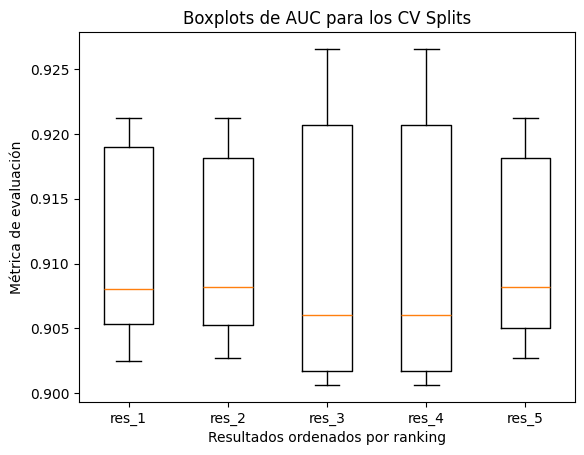

In [39]:
sorted_results_arbol = model_results(grid_search_arbol)

In [40]:
best_tree_model_params = sorted_results_arbol.iloc[0].params

modelo_ganador_arbol = DecisionTreeClassifier(
    **best_tree_model_params, random_state=SEED
)

modelo_ganador_arbol.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_split=100, random_state=12345)

In [41]:
goodness_of_fit(modelo_ganador_arbol, X_test, y_test)

Matriz de Confusión:
[[1873  465]
 [ 537 2598]]

Medidas de Desempeño:
              precision    recall  f1-score   support

           0       0.78      0.80      0.79      2338
           1       0.85      0.83      0.84      3135

    accuracy                           0.82      5473
   macro avg       0.81      0.81      0.81      5473
weighted avg       0.82      0.82      0.82      5473




Área bajo la curva ROC (AUC): 0.91117


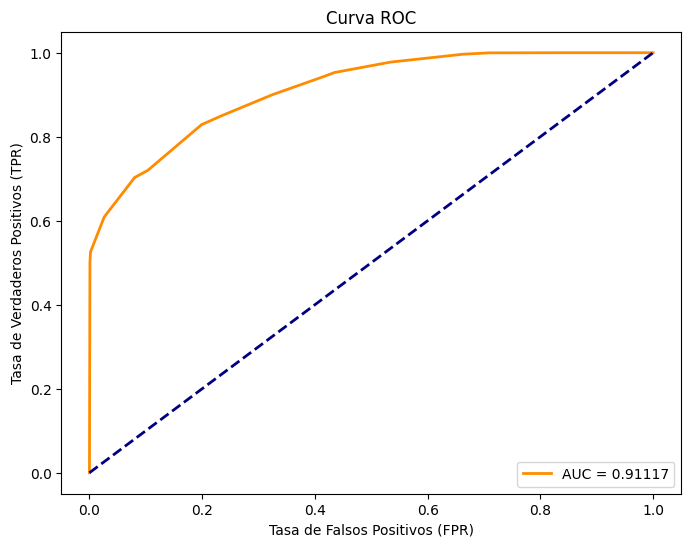

In [42]:
plot_roc_curve(modelo_ganador_arbol, X_test, y_test)

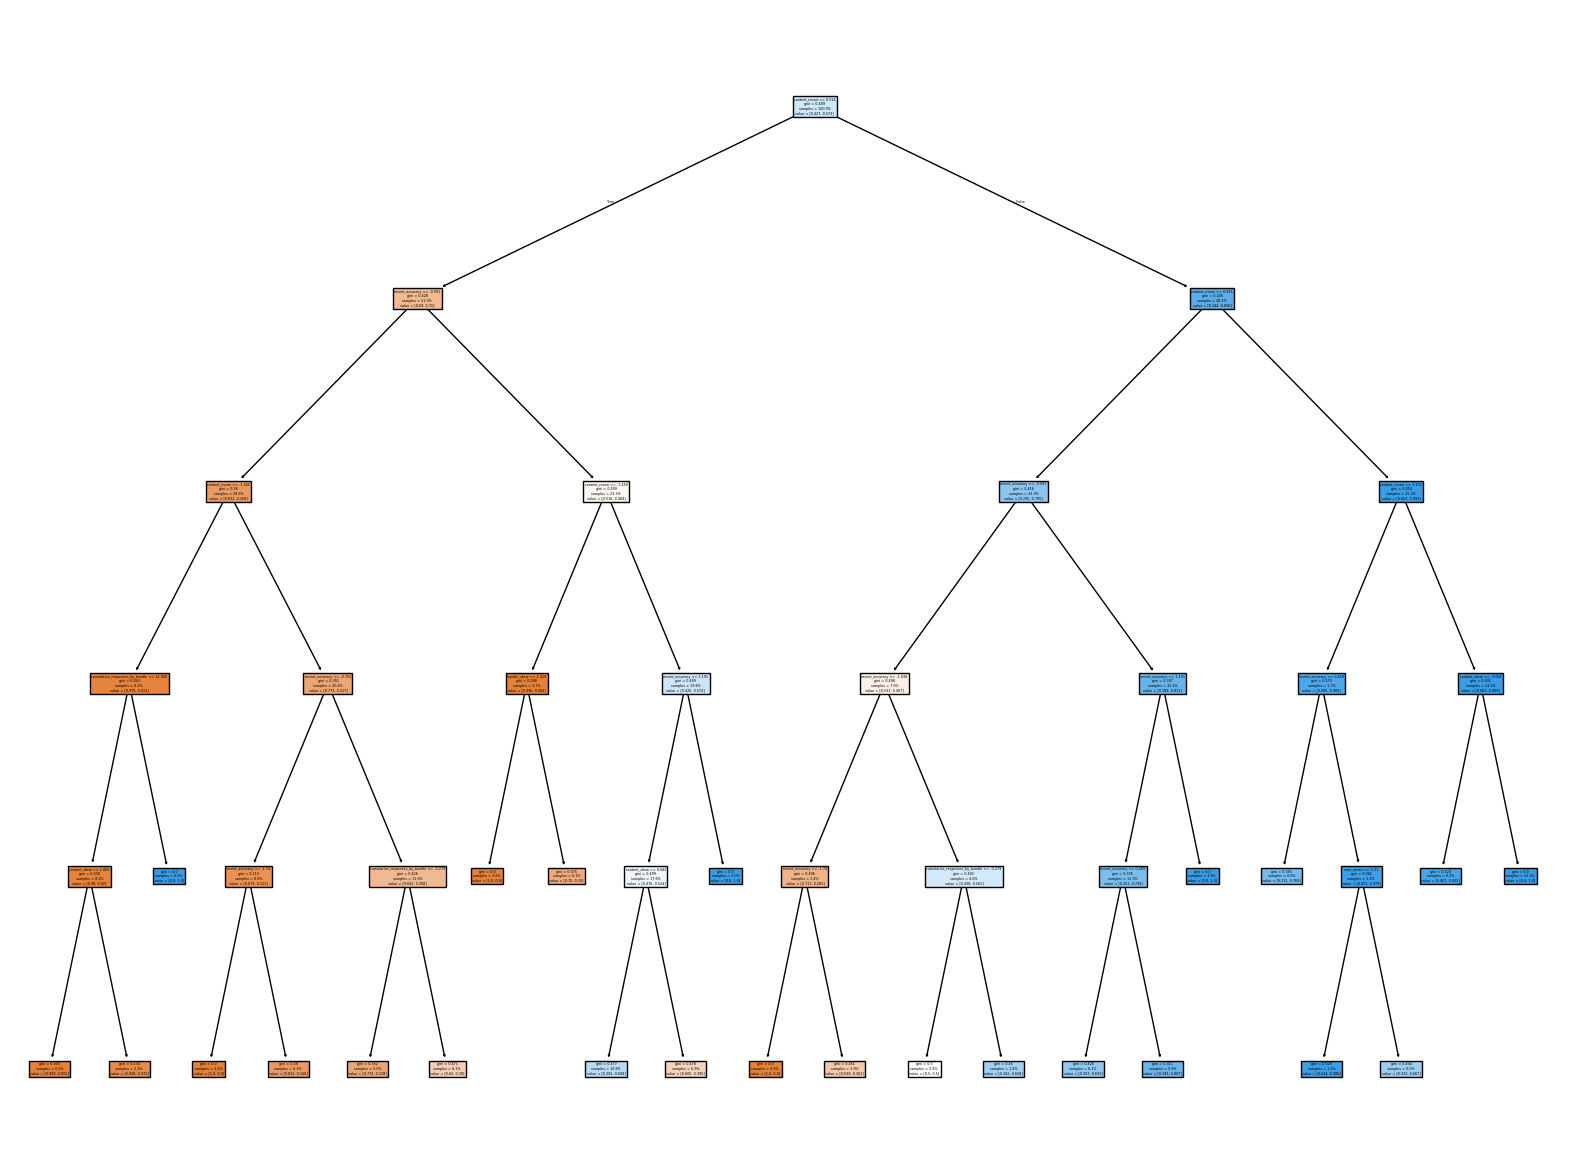

In [43]:
# Visualizar el arbol del modelo ganador
plt.figure(figsize=(20, 15))
plot_tree(
    modelo_ganador_arbol,
    feature_names=X_train.columns.tolist(),
    filled=True,
    proportion=True,
)

plt.show()

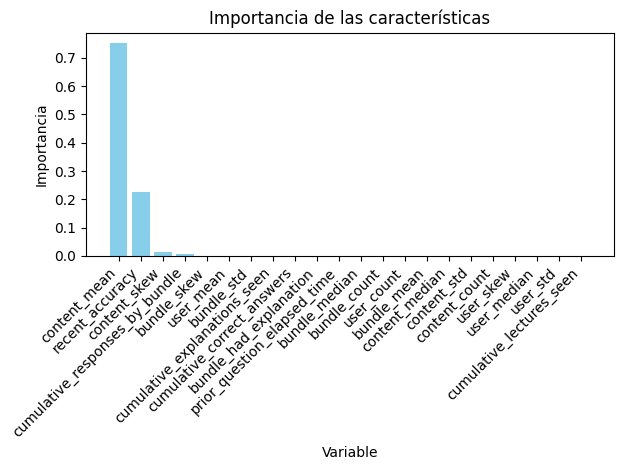

In [44]:
plot_features_importance(modelo_ganador_arbol)

In [45]:
model_path = ML_DIR + "decision_tree.pkl"
pickle.dump(modelo_ganador_arbol, open(model_path, "wb"))

## Random Forest


In [46]:
modelo_rf = RandomForestClassifier(random_state=SEED)

params = {
    "n_estimators": [50, 100, 150, 200, 250],
    "max_depth": [2, 3, 5, 10, 20],
    "bootstrap": [False],
    "min_samples_leaf": [3, 10, 30],
    "min_samples_split": [5, 10, 20, 50, 100],
    "criterion": ["gini", "entropy"],
}

random_search_rf = RandomizedSearchCV(
    estimator=modelo_rf,
    param_distributions=params,
    n_iter=50,
    scoring="roc_auc",
    cv=3,
    verbose=2,
    random_state=SEED,
    n_jobs=-1,
)
random_search_rf.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=12345),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 3, 5, 10, 20],
                                        'min_samples_leaf': [3, 10, 30],
                                        'min_samples_split': [5, 10, 20, 50,
                                                              100],
                                        'n_estimators': [50, 100, 150, 200,
                                                         250]},
                   random_state=12345, scoring='roc_auc', verbose=2)

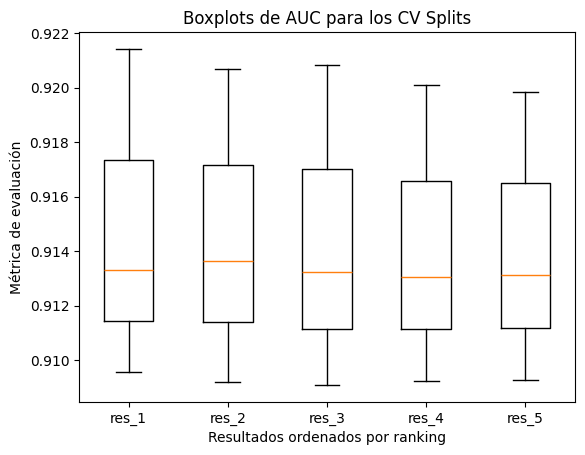

In [47]:
sorted_results_rf = model_results(random_search_rf)

In [48]:
best_rf_model_params = sorted_results_rf.iloc[2].params

modelo_ganador_rf = RandomForestClassifier(**best_rf_model_params, random_state=SEED)
modelo_ganador_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=10,
                       min_samples_leaf=10, min_samples_split=50,
                       n_estimators=150, random_state=12345)

In [49]:
goodness_of_fit(modelo_ganador_rf, X_test, y_test)

Matriz de Confusión:
[[1806  532]
 [ 482 2653]]

Medidas de Desempeño:
              precision    recall  f1-score   support

           0       0.79      0.77      0.78      2338
           1       0.83      0.85      0.84      3135

    accuracy                           0.81      5473
   macro avg       0.81      0.81      0.81      5473
weighted avg       0.81      0.81      0.81      5473




Área bajo la curva ROC (AUC): 0.91299


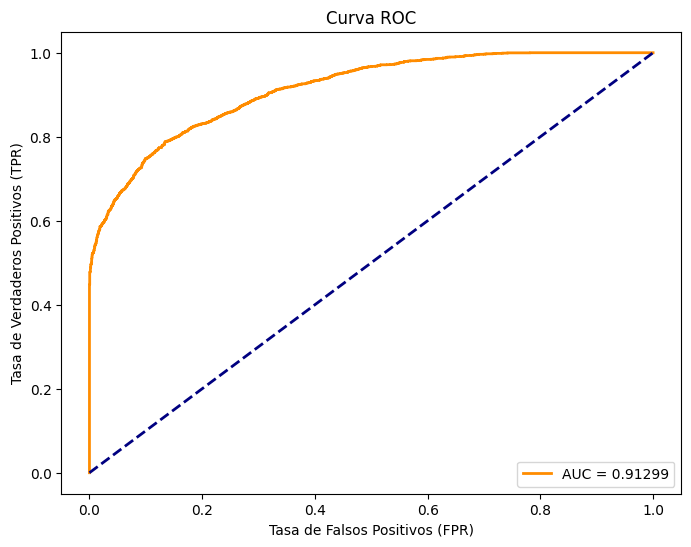

In [50]:
plot_roc_curve(modelo_ganador_rf, X_test, y_test)

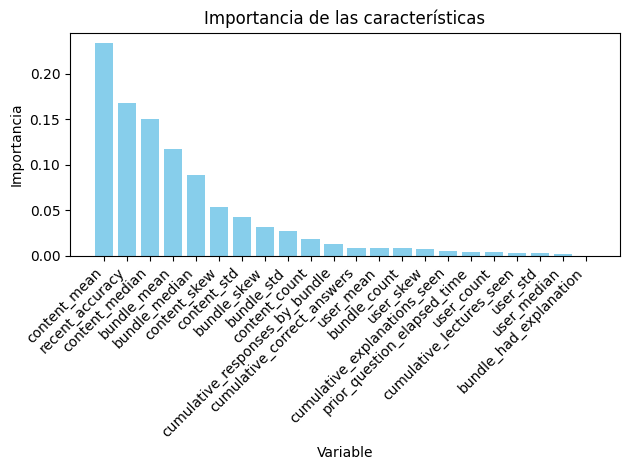

In [51]:
plot_features_importance(modelo_ganador_rf)

In [52]:
model_path = ML_DIR + "random_forest.pkl"
pickle.dump(modelo_ganador_rf, open(model_path, "wb"))

## XGBoost


In [53]:
modelo_xgb = XGBClassifier(
    tree_method="gpu_hist",
    objective="binary:logistic",
    use_label_encoder=False,
    eval_metric="auc",
    random_state=SEED,
)

params = {
    "eta": [0.01, 0.05, 0.1, 0.2, 0.3],
    "max_depth": [3, 4, 5, 6, 7],
    "gamma": [0, 0.1, 0.2, 0.3],
    "subsample": [0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.8, 0.9, 1.0],
    "n_estimators": [100, 200, 300, 500],
}

random_search_xgb = RandomizedSearchCV(
    estimator=modelo_xgb,
    param_distributions=params,
    n_iter=50,
    scoring="roc_auc",
    cv=3,
    verbose=2,
    random_state=SEED,
    n_jobs=-1,
)

random_search_xgb.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rat...
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=12345, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 0.9,
                                                             1.0],
                                        'eta': [0.01, 0.05, 0.1, 0.2, 0.3],
                                        'gamma': [0, 0.1, 0.2, 0.3],
                                        'max_depth': [3, 4, 5, 6, 7],
                                        'n_estimators': [100, 200, 300, 500],
                                        'subsample': [0.7, 0.8, 0.9, 1.0]},
                   random_state=12345, scoring='roc_auc', verbose=2)

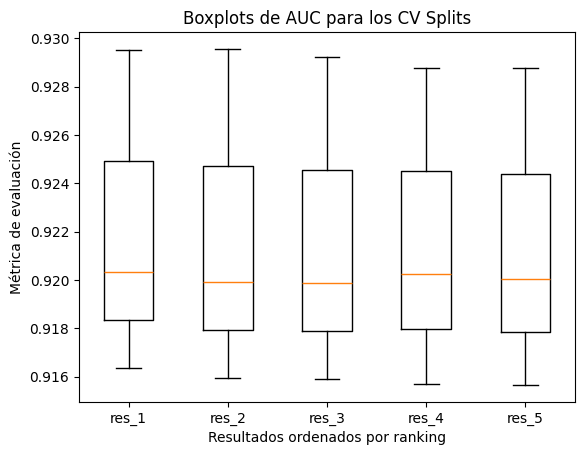

In [54]:
sorted_results_xgb = model_results(random_search_xgb)

In [55]:
best_xgb_model_params = sorted_results_xgb.iloc[0].params

modelo_ganador_xgb = XGBClassifier(**best_xgb_model_params, random_state=SEED)
modelo_ganador_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.01, eval_metric=None,
              feature_types=None, gamma=0.3, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

In [56]:
goodness_of_fit(modelo_ganador_xgb, X_test, y_test)

Matriz de Confusión:
[[1802  536]
 [ 441 2694]]

Medidas de Desempeño:
              precision    recall  f1-score   support

           0       0.80      0.77      0.79      2338
           1       0.83      0.86      0.85      3135

    accuracy                           0.82      5473
   macro avg       0.82      0.82      0.82      5473
weighted avg       0.82      0.82      0.82      5473




Área bajo la curva ROC (AUC): 0.92085


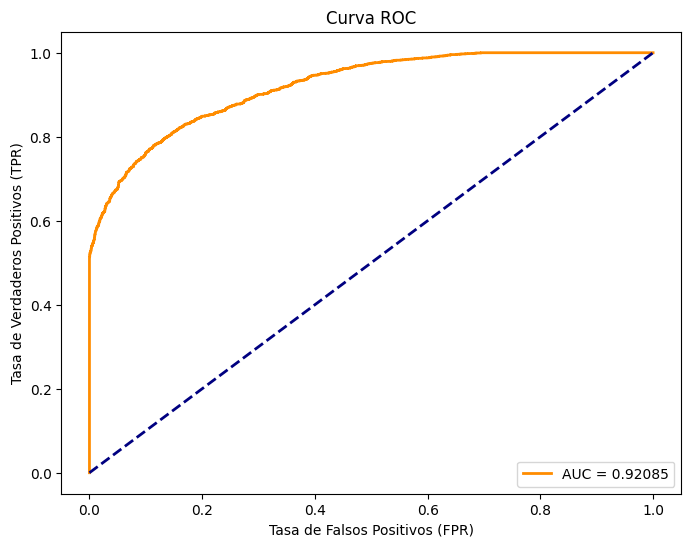

In [57]:
plot_roc_curve(modelo_ganador_xgb, X_test, y_test)

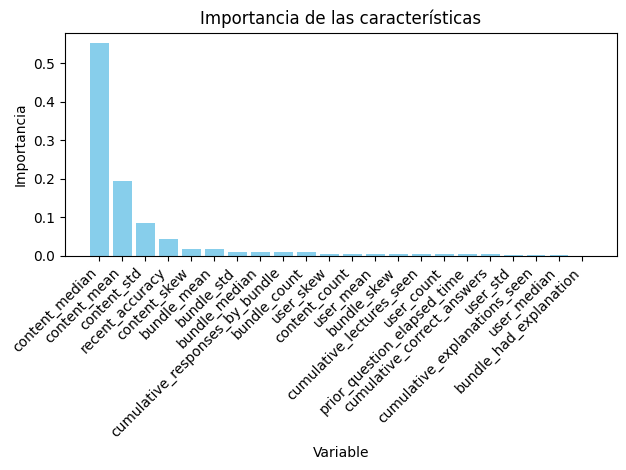

In [58]:
plot_features_importance(modelo_ganador_xgb)

In [59]:
model_path = ML_DIR + "xgboost.pkl"
pickle.dump(modelo_ganador_xgb, open(model_path, "wb"))

## LightGBM


In [60]:
lgbm_model = lgbm.LGBMClassifier(random_state=SEED)

param_distributions = {
    "num_leaves": [20, 31, 50, 100],
    "max_depth": [-1, 10, 20, 30],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "n_estimators": [100, 200, 500],
    "min_child_samples": [10, 20, 30],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
}

random_search_lgbm = RandomizedSearchCV(
    estimator=lgbm_model,
    param_distributions=param_distributions,
    n_iter=50,
    scoring="roc_auc",
    cv=3,
    verbose=1,
    random_state=SEED,
    n_jobs=-1,
)
random_search_lgbm.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[LightGBM] [Info] Number of positive: 7314, number of negative: 5456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2312
[LightGBM] [Info] Number of data points in the train set: 12770, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.572749 -> initscore=0.293074
[LightGBM] [Info] Start training from score 0.293074


RandomizedSearchCV(cv=3, estimator=LGBMClassifier(random_state=12345),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [-1, 10, 20, 30],
                                        'min_child_samples': [10, 20, 30],
                                        'n_estimators': [100, 200, 500],
                                        'num_leaves': [20, 31, 50, 100],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=12345, scoring='roc_auc', verbose=1)

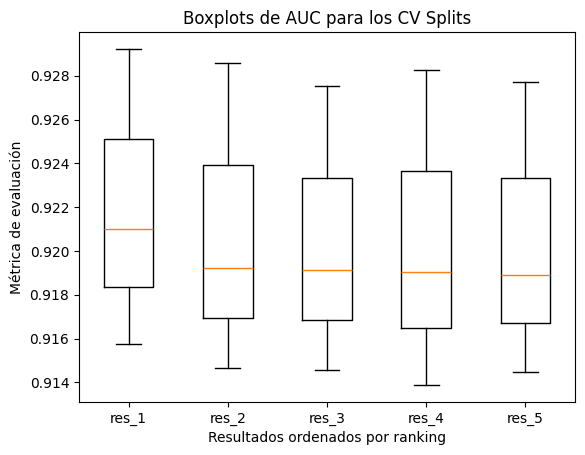

In [61]:
sorted_results_lgbm = model_results(random_search_lgbm)

In [62]:
best_lgbm_model_params = sorted_results_lgbm.iloc[0].params

modelo_ganador_lgbm = lgbm.LGBMClassifier(**best_lgbm_model_params, random_state=SEED)
modelo_ganador_lgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 7314, number of negative: 5456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2312
[LightGBM] [Info] Number of data points in the train set: 12770, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.572749 -> initscore=0.293074
[LightGBM] [Info] Start training from score 0.293074


LGBMClassifier(learning_rate=0.05, max_depth=20, min_child_samples=30,
               num_leaves=20, random_state=12345, subsample=0.8)

In [63]:
goodness_of_fit(modelo_ganador_lgbm, X_test, y_test)

Matriz de Confusión:
[[1882  456]
 [ 497 2638]]

Medidas de Desempeño:
              precision    recall  f1-score   support

           0       0.79      0.80      0.80      2338
           1       0.85      0.84      0.85      3135

    accuracy                           0.83      5473
   macro avg       0.82      0.82      0.82      5473
weighted avg       0.83      0.83      0.83      5473




Área bajo la curva ROC (AUC): 0.92134


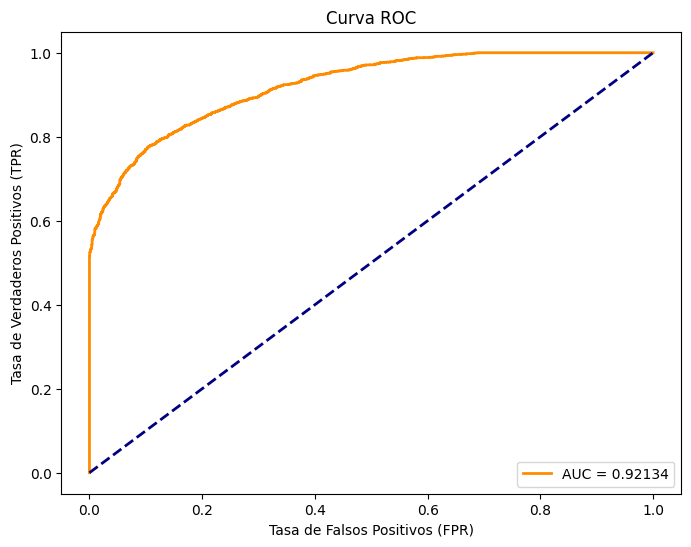

In [64]:
plot_roc_curve(modelo_ganador_lgbm, X_test, y_test)

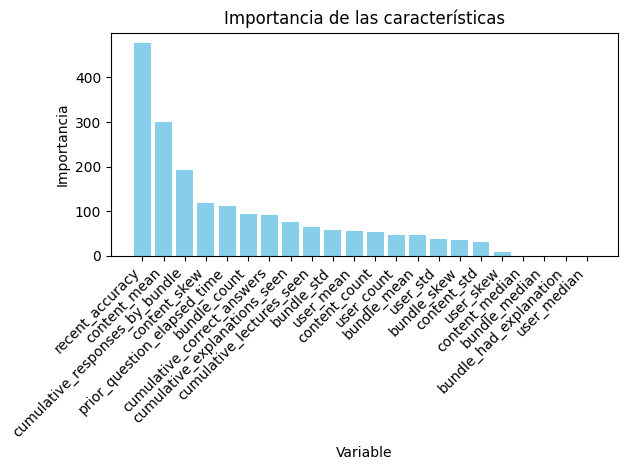

In [65]:
plot_features_importance(modelo_ganador_lgbm)

In [66]:
model_path = ML_DIR + "lightgbm.pkl"
pickle.dump(modelo_ganador_lgbm, open(model_path, "wb"))

## Stacking


In [67]:
if "modelo_ganador_arbol" not in globals():
    modelo_ganador_arbol = load_ml_model("dt", ML_DIR)

if "modelo_ganador_rf" not in globals():
    modelo_ganador_rf = load_ml_model("rf", ML_DIR)

if "modelo_ganador_xgb" not in globals():
    modelo_ganador_xgb = load_ml_model("xgb", ML_DIR)

if "modelo_ganador_lgbm" not in globals():
    modelo_ganador_lgbm = load_ml_model("lgbm", ML_DIR)

base_models = [
    ("dt", modelo_ganador_arbol),
    ("rf", modelo_ganador_rf),
    ("xgb", modelo_ganador_xgb),
    ("lgbm", modelo_ganador_lgbm),
]

meta_model = LogisticRegression(random_state=SEED)

stacking_clf = StackingClassifier(
    estimators=base_models, final_estimator=meta_model, cv=5
)

stacking_clf.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 7314, number of negative: 5456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2312
[LightGBM] [Info] Number of data points in the train set: 12770, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.572749 -> initscore=0.293074
[LightGBM] [Info] Start training from score 0.293074
[LightGBM] [Info] Number of positive: 5851, number of negative: 4365
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2304
[LightGBM] [Info] Number of data points in the train set: 10216, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.572729 -> initscore=0.292994
[LightGBM] [Info] Start training from score 0.292994
[LightGBM] [Info] Nu

StackingClassifier(cv=5,
                   estimators=[('dt',
                                DecisionTreeClassifier(max_depth=5,
                                                       min_samples_split=100,
                                                       random_state=12345)),
                               ('rf',
                                RandomForestClassifier(bootstrap=False,
                                                       criterion='entropy',
                                                       max_depth=10,
                                                       min_samples_leaf=10,
                                                       min_samples_split=50,
                                                       n_estimators=150,
                                                       random_state=12345)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsampl...
                                              max_delta_step=None, max_depth=6,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=300, n_jobs=None,
                                              num_parallel_tree=None, ...)),
                               ('lgbm',
                                LGBMClassifier(learning_rate=0.05, max_depth=20,
                                               min_child_samples=30,
                                               num_leaves=20,
                                               random_state=12345,
                                               subsample=0.8))],
                   final_estimator=LogisticRegression(random_state=12345))

In [68]:
goodness_of_fit(stacking_clf, X_test, y_test)

Matriz de Confusión:
[[1812  526]
 [ 440 2695]]

Medidas de Desempeño:
              precision    recall  f1-score   support

           0       0.80      0.78      0.79      2338
           1       0.84      0.86      0.85      3135

    accuracy                           0.82      5473
   macro avg       0.82      0.82      0.82      5473
weighted avg       0.82      0.82      0.82      5473




Área bajo la curva ROC (AUC): 0.92143


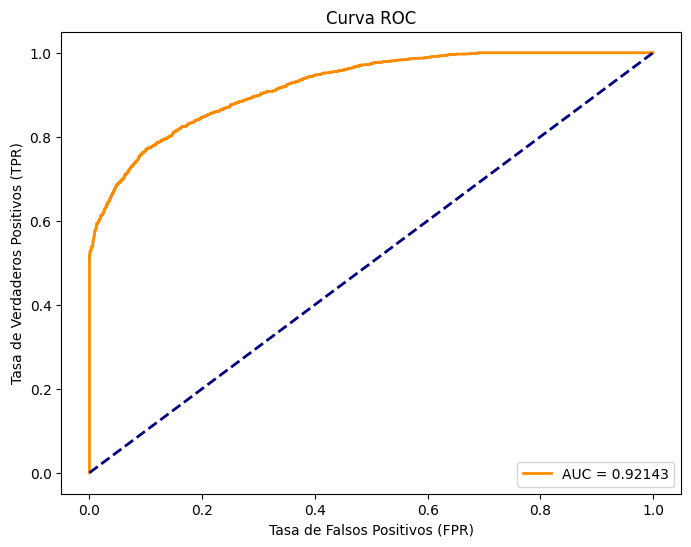

In [69]:
plot_roc_curve(stacking_clf, X_test, y_test)

In [70]:
model_path = ML_DIR + "stacking.pkl"
pickle.dump(stacking_clf, open(model_path, "wb"))

# Deep Learning


## Feature Engineering


In [71]:
tf.random.set_seed(SEED)

In [72]:
questions_df = create_feature_df(df)
questions_df.columns

Index(['timestamp', 'item_id', 'user_answer', 'user_id', 'content_type',
       'bundle_id', 'answered_correctly', 'content_id', 'elapsed_time',
       'bundle_had_explanation', 'prior_question_elapsed_time',
       'cumulative_correct_answers', 'recent_accuracy',
       'cumulative_explanations_seen', 'cumulative_lectures_seen',
       'cumulative_responses_by_bundle', 'user_mean', 'user_count', 'user_std',
       'user_median', 'user_skew', 'content_mean', 'content_count',
       'content_std', 'content_median', 'content_skew', 'bundle_mean',
       'bundle_count', 'bundle_std', 'bundle_median', 'bundle_skew'],
      dtype='object')

In [73]:
features = [
    "user_mean",
    "user_count",
    "user_std",
    "user_median",
    "user_skew",
    "content_mean",
    "content_count",
    "content_std",
    "content_median",
    "content_skew",
    "bundle_mean",
    "bundle_count",
    "bundle_std",
    "bundle_median",
    "bundle_skew",
    "prior_question_elapsed_time",
    "bundle_had_explanation",
    "cumulative_correct_answers",
    "recent_accuracy",
    "cumulative_responses_by_bundle",
    "cumulative_explanations_seen",
    "cumulative_lectures_seen",
]
target = "answered_correctly"

dl_df = questions_df[features + [target]]

In [74]:
dl_df = fill_missing_values(dl_df, features)
dl_df = scale_data(
    features_data=dl_df, train=True, features_to_keep=features, target=target
)

In [75]:
X = dl_df[features]
y = dl_df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=SEED, test_size=0.3, stratify=y
)

## Logistic Regresion


### Keras LR


In [76]:
model_lr, history_lr = get_keras_lr_model(X_train, y_train, X_test, y_test, DL_DIR)

No se encontró modelo en ./trained_models/deep_learning/model\logistic_regresion.h5 o historial en ./trained_models/deep_learning/history\logistic_regresion.pkl, construyendo uno nuevo.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inp (InputLayer)            [(None, 22)]              0         
                                                                 
 dense (Dense)               (None, 512)               11776     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 gaussian_noise (GaussianNo  (None, 512)               0         
 ise)                                                            
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normal

In [77]:
results_lr = model_lr.evaluate(X_test, y_test, verbose=0, batch_size=1000)
print("Test Loss: {}".format(results_lr[0]))
print("Test AUC: {}".format(results_lr[1]))

Test Loss: 0.3967415392398834
Test AUC: 0.9195289015769958


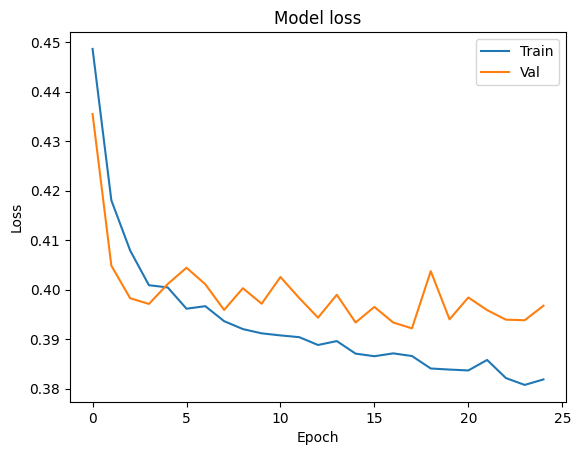

In [78]:
plot_history(history_lr)

### Keras Tuner LR


In [79]:
tunner_dir = DL_DIR + "model/"
model_tuner_lr, tuner = get_tuner_lr_model(X_train, y_train, X_test, y_test, tunner_dir)

Trial 30 Complete [00h 00m 07s]
val_auc: 0.919184148311615

Best val_auc So Far: 0.9197583794593811
Total elapsed time: 00h 02m 50s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 224)               5152      
                                                                 
 dropout (Dropout)           (None, 224)               0         
                                                                 
 dense_1 (Dense)             (None, 160)               36000     
                                                                 
 dropout_1 (Dropout)         (None, 160)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                5152      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0

In [80]:
loss, auc_test = model_tuner_lr.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss}")
print(f"Test AUC: {auc_test}")

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(best_hps.values)

Test Loss: 0.338707834482193
Test AUC: 0.9197583794593811
Best Hyperparameters:
{'num_layers': 3, 'units_0': 224, 'dropout_0': 0.0, 'learning_rate': 0.00022491452958964034, 'units_1': 160, 'dropout_1': 0.4, 'units_2': 32, 'dropout_2': 0.2, 'tuner/epochs': 20, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


## LSTM


In [81]:
X_lstm_train = reshape_lstm_data(X_train)
X_lstm_test = reshape_lstm_data(X_test)

In [82]:
model_lstm, history_lstm = get_lstm_model(
    X_lstm_train, y_train, X_lstm_test, y_test, DL_DIR
)

No se encontró modelo en ./trained_models/deep_learning/model\lstm.h5 o historial en ./trained_models/deep_learning/history\lstm.pkl, construyendo uno nuevo.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 50)             14600     
                                                                 
 lstm_1 (LSTM)               (None, 150)               120600    
                                                                 
 dense_4 (Dense)             (None, 64)                9664      
                                                                 
 dense_5 (Dense)             (None, 128)               8320      
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense_6 (Dense)            

In [83]:
results_lstm = model_lstm.evaluate(X_lstm_test, y_test, verbose=0, batch_size=1000)
print("Test Loss: {}".format(results_lstm[0]))
print("Test AUC: {}".format(results_lstm[1]))

Test Loss: 0.34344327449798584
Test AUC: 0.9184490442276001


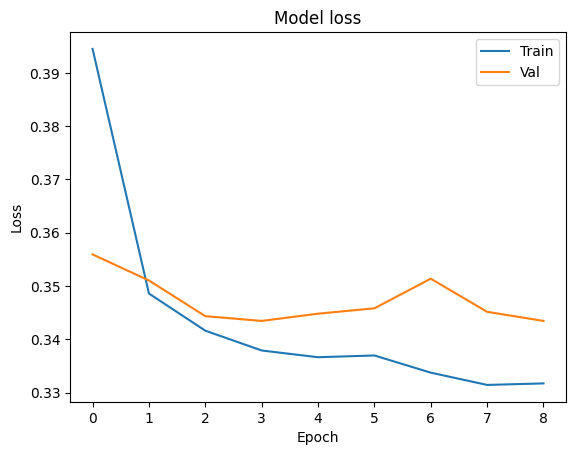

In [84]:
plot_history(history_lstm)

## CNN


In [85]:
X_cnn_train = reshape_cnn_data(X_train)
X_cnn_test = reshape_cnn_data(X_test)

In [86]:
model_cnn, history_cnn = get_cnn_model(X_cnn_train, y_train, X_cnn_test, y_test, DL_DIR)

No se encontró modelo en ./trained_models/deep_learning/model\cnn.h5 o historial en ./trained_models/deep_learning/history\cnn.pkl, construyendo uno nuevo.
Epoch 1/25
200/200 [==============================] - 3s 11ms/step - loss: 0.4193 - auc_2: 0.8807 - val_loss: 0.3581 - val_auc_2: 0.9124
Epoch 2/25
200/200 [==============================] - 2s 10ms/step - loss: 0.3700 - auc_2: 0.9063 - val_loss: 0.3500 - val_auc_2: 0.9144
Epoch 3/25
200/200 [==============================] - 2s 10ms/step - loss: 0.3599 - auc_2: 0.9105 - val_loss: 0.3528 - val_auc_2: 0.9162
Epoch 4/25
200/200 [==============================] - 2s 9ms/step - loss: 0.3549 - auc_2: 0.9126 - val_loss: 0.3504 - val_auc_2: 0.9168
Epoch 5/25
200/200 [==============================] - 2s 10ms/step - loss: 0.3529 - auc_2: 0.9134 - val_loss: 0.3472 - val_auc_2: 0.9160
Epoch 6/25
200/200 [==============================] - 2s 9ms/step - loss: 0.3495 - auc_2: 0.9152 - val_loss: 0.3451 - val_auc_2: 0.9179
Epoch 7/25
200/200 [====

In [87]:
results_cnn = model_cnn.evaluate(X_cnn_test, y_test, verbose=0, batch_size=1000)
print("Test Loss: {}".format(results_cnn[0]))
print("Test AUC: {}".format(results_cnn[1]))

Test Loss: 0.33739760518074036
Test AUC: 0.9200763702392578


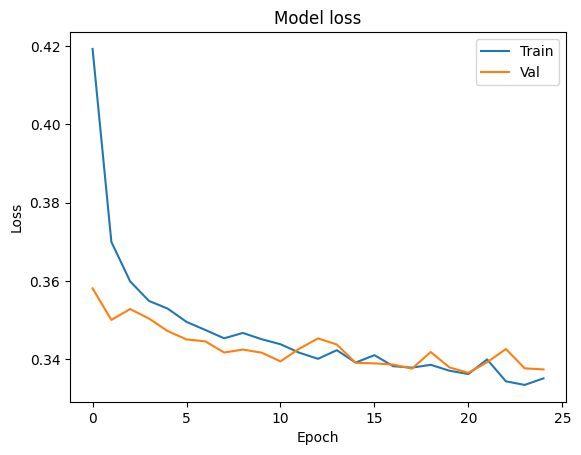

In [88]:
plot_history(history_cnn)